In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

numpyro.set_host_device_count(8)
sns.set_theme('notebook', 'ticks', 'colorblind')

A bit of discussion of what's going on here.  We assume that we have a set of samples of some parameters in $N$ dimensions for each event:
$$
\theta_{ijk},
$$
where $0 \leq i < N_\mathrm{evt}$, $0 \leq j < N_\mathrm{samples}$ (we use a "square" array of samples for convenience, but this could straightforwardly be made ragged at the cost of a bit more bookkeeping), and $0 \leq k < N$.  The samples are drawn according to some prior density, so come with a prior "weight," $\pi_{ij}$.

For some of these parameters, say (without loss of generality) the first $N_g \leq N$ of them, we wish to impose a multivariate Gaussian population with mean $\mathbf{\mu}$ and covariance matrix $\mathbf{\Sigma}$:
$$
p\left( \mathbf{\theta}_{k<N_g} \mid \mu\left(\Lambda\right), \Sigma\left(\Lambda \right) \right) = \frac{1}{\sqrt{\det 2 \pi \mathbf{\Sigma}}} \exp\left( -\frac{1}{2} \left( \theta_{k'} - \mu_{k'} \right) \left( \Sigma^{-1} \right)^{k' k} \left( \theta_{k} - \mu_k\right) \right).
$$
Suppose for the rest of the parameters, $N_g \leq k < N$, we want to use a different (arbitrary) population,
$$
p\left( \mathbf{\theta}_{k\geq N_g} \mid \Lambda \right).
$$
For full generality we have let the Gaussian mean and covariance parameters depend on $\Lambda$ though this complication will not be present in the code below.  (In words: we want the population of the first $k < N_g$ parameters to be *conditionally* Gaussian at fixed values of the other parameters.)

We can, of course, treat this in the usual hierarchical way, averaging the full population (a product of the multivariate normal components and the other population) over the samples to compute the per-event likelihood function.  But if we do this, we will "run out of samples" if $\mathbf{\Sigma}$ becomes small, because the population is restricted to a narrow region in parameter space, perhaps *between* any of the samples we have obtained.  Even if the failure is not this dramatic, we may still require very, very many samples in order to adequately represent the likelihood function on the scales over which the population varies (in particular, if the population is quite narrow, for a long time we will see our computing requirements grow super-linearly with catalog size, as each successive catalog produces fits to the population that are narrower and narrower).

The problem referred to above, though, is merely that the discrete samples do not do a good job of representing the (smooth on small scales) likelihood function.  (It is different from other causes of small effective sample number in the importance marginalization, like a mismatch between population and likelihood---outliers---in that, ultimately, we expect all likelihoods to be smooth on small scales, so it is not some fundamental issue of needing lots of samples to properly determine the likelihood, but rather just that any finite set of samples becomes discrete on some---rather large---scale.)  One way to fix this problem is to use a Gaussian KDE approximation to the likelihood function; such an approximation guarantees smoothness on small scales, and therefore completely solves the issue.

A Gaussian KDE approximation to the likelihood is *also* beneficial in that we can integrate the true parameter out of the likelihood analytically because the dependence of the posterior on $\theta_{k<N_g}$ is a product of Gaussians.  Let us factor the prior into a conditional term and marginal term:
$$
p\left( \theta_k \right) = p\left( \theta_{k < N_g} \mid \theta_{k \geq N_g} \right) p\left( \theta_{k \geq N_g} \right).
$$
Then the weight for each sample also factors 
$$
\pi_{ij} = \pi_{g,ij} \pi_{ng,ij},
$$
where 
$$
\pi_{g,ij} = p\left( \theta_{k<N_g} \mid \theta_{k \geq N_g} \right)
$$
is the conditional piece of the prior and $\pi_{ng,ij}$ is the marginal prior on the $N_g \leq k < N$ parameters. 

We want to represent the *conditional* likelihood function as a Gaussian KDE, leaving samples for the $k \geq N_g$ dimensions.  Choosing some bandwidth $\mathbf{\Sigma}_{bw,i}$ for each event $i$ (more on this below), we will approximate the likelihood:
$$
p\left( d_i \mid \theta_{ik} \right) \propto \frac{1}{W_i} \sum_j w_{ij} \phi\left( \theta_{ik<N_g} \mid \theta_{ijk<N_g}, \mathbf{\Sigma}_{bw,i} \right) \frac{\delta\left( \theta_{ik\geq N_g} - \theta_{ijk \geq N_g} \right)}{\pi_{ng,ij}},
$$
where $\phi\left( \mathbf{x} \mid \mathbf{\mu}, \mathbf{\Sigma} \right)$ is the multivariate normal density.  The weight factor $w_{ij} = 1/\pi_{g,ij}$ cancels the conditional prior on the Gaussian population component, and $\pi_{ng,ij}$ takes care of the non-Gaussian components.  $W_i \equiv \sum_j w_{ij}$ is a normalizing factor (that can be ignored during sampling).

Each event generates a term in the joint posterior like 
$$
p\left( d_i \mid \theta_{ik} \right) p\left( \theta_{ik<N_g} \mid \mu\left(\Lambda\right), \mathbf{\Sigma}\left(\Lambda\right) \right) p\left( \theta_{ik \geq N_g} \mid \Lambda \right).
$$
Integrating over $\theta_{ik}$, the (latent) true parameter $\theta$ for event $i$ and using our Gaussian KDE / delta-function approximation to the , we obtain
$$
\int \mathrm{d} \theta_{ik} \, p\left( d_i \mid \theta_{ik} \right) p\left( \theta_{ik<N_g} \mid \mu\left(\Lambda\right), \mathbf{\Sigma}\left(\Lambda\right) \right) p\left( \theta_{ik \geq N_g} \mid \Lambda \right) = \frac{1}{W_i} \sum_j w_{ij} \phi\left( \theta_{ijk<N_g} \mid \mathbf{\mu}, \mathbf{\Sigma} + \mathbf{\Sigma}_{bw,i} \right) \frac{p\left( \theta_{ijk \geq N_g} \mid \Lambda \right)}{\pi_{ng,ij}}.
$$
This likelihood function is implemented below.

The remaining trick is to choose the "right" bandwidth $\mathbf{\Sigma}_{bw,i}$ for each event's samples $i$.  For a Gaussian KDE, the standard Scott's rule is to choose 
$$
\Sigma_{bw} = \frac{\mathrm{cov} \left( \mathbf{\theta} \right)}{N_\mathrm{samples}^{2/(4 + N)}}.
$$
But for us, we only want to represent the *conditional* density (over $N_g \leq N$ dimensions) as a Gaussian KDE; and we have weights $w_{ij}$ that treat the samples non-uniformly.  A possible solution is to use in place of the full covariance the *conditional* covariance (which can be obtained by computing the full covariance, inverting the matrix, extracting the $N_g \times N_g$ upper left corner, and inverting *that* to obtain the covariance over $\theta_{k<N_g}$ with $\theta_{k \geq N_g}$ held fixed).  And, instead of using $N_\mathrm{samples}$ we use 
$$
N_{\mathrm{eff},i} = \frac{\left( \sum_j w_{ij} \right)^2}{\sum_j w_{ij}^2},
$$
and compute the *weighted* covariance. 

For the moment, the code below assumes that the population covariance is diagonal (so the elements of the population that are treated as Gaussians are independent of each other); but extending to treat correlations in this population is straightforward.

In [3]:
def conditional_covariance(samples, n, wts=None):
    r"""
    The conditional covariance of samples over the first `n` dimensions.

    Returns the covariance over the first `n` dimensions as the remaining
    dimensions are fixed.  In math

    .. math::
        \mathrm{cov}_n \equiv \left[ \left( \Sigma^{-1} \right)(1:n, 1:n) \right]^{-1}
    
    :param samples: An array of shape `(..., nsamp, ndim)`.

    :param n: An integer, `n <= ndim`.

    :param wts: (Optional) Array of shape `(..., nsamp)` giving the associated
        sample weights.

    :return: An `(..., n, n)` array of the (weighted) conditional covariance of
        the first `n` dimensions of the samples in `samples`.
    """
    samples = np.atleast_2d(samples)
    if wts is None:
        wts = np.ones(samples.shape[:-1])
    W = np.sum(wts, axis=-1)

    mu = np.sum(wts[..., None]*samples, axis=-2) / W[..., None]
    cov = np.sum(wts[..., None, None]*(samples[..., None, :] - mu[..., None, None, :])*(samples[..., :, None] - mu[..., None, :, None]), axis=-3) / W[..., None, None]

    prec = np.linalg.inv(cov)

    sub_prec = prec[..., :n, :n]
    return np.linalg.inv(sub_prec)

In [4]:
def jnp_logsumexp(xs, axis=None):
    xs = jnp.atleast_1d(xs)

    x_max = jnp.max(xs, axis=axis)
    if axis is not None:
        x_max_expanded = jnp.expand_dims(x_max, axis=axis)
    else:
        x_max_expanded = x_max

    return x_max + jnp.log(jnp.sum(jnp.exp(xs - x_max_expanded), axis=axis))

In [ ]:
def pl_to_gaussian(a, expansion_pt):
    mu = 2 expansion_pt
    sigma = expansion_pt / jnp.sqrt(a)

In [108]:
def make_partial_normal_normal_model(samples, prior_wts_normal, prior_wts_other, n_normal, kde_marg=True):
    nobs, nsamp, ndim = samples.shape
    n_other = ndim - n_normal
    assert prior_wts_normal.shape == (nobs, nsamp), 'incorrect shape in prior_wts_normal'
    assert prior_wts_other.shape == (nobs, nsamp), 'incorrect shape in prior_wts_other'

    wts = 1/prior_wts_normal
    w = np.sum(wts, axis=-1)
    theta_cov_normal = conditional_covariance(samples, n_normal, wts=wts)

    log_normal_wts = np.log(wts) # (nobs, nsamp)
    log_normal_w = np.log(w) # (nobs,)
    log_other_wts = np.log(prior_wts_other) # (nobs, nsamp)

    neff = np.square(np.sum(wts, axis=1)) / np.sum(np.square(wts), axis=1)
    kde_bw = theta_cov_normal / neff[:,None,None]**(2 / (4 + n_normal)) # Scott's rule; shape is (nobs, n_normal, n_normal)

    mu = numpyro.sample('mu', dist.Normal(0, 1), sample_shape=(n_normal,))
    sigma = numpyro.sample('sigma', dist.HalfNormal(1), sample_shape=(n_normal,))

    alpha = numpyro.sample('alpha', dist.Uniform(1, 4))
    beta = numpyro.sample('beta', dist.Uniform(-0.5, 0.5))

    if kde_marg:
        sigma_evts = kde_bw + jnp.diag(jnp.square(sigma))
        logp_normal = dist.MultivariateNormal(mu[None, None, :], sigma_evts[:, None, :, :]).log_prob(samples[:,:,:n_normal])
    else:
        sigma_evts = jnp.diag(jnp.square(sigma))
        logp_normal = dist.MultivariateNormal(mu[None, None, :], sigma_evts[None, None, :, :]).log_prob(samples[:,:,:n_normal])

    qs = samples[:, :, 2]
    m1s = samples[:, :, 3]
    logp_other = -alpha*jnp.log(m1s) + jnp.log(alpha-1) + beta*jnp.log(qs) + jnp.log1p(beta)

    logp_total = logp_normal + log_normal_wts - log_normal_w[:, None] + logp_other - log_other_wts
    logp_summed = jnp_logsumexp(logp_total, axis=1)

    neff = numpyro.deterministic('neff', jnp.exp(2*logp_summed - jnp_logsumexp(2*logp_total, axis=1)))

    numpyro.factor('log_likelihood', jnp.sum(logp_summed))

Let's build a reasonable LIGO-ish observational model.  We're gonna do BBH systems here (because why not).  So the true masses are distributed as a power law in $m_1$, power law in $q$ conditional on $m_1$, gaussian in $\chi_\mathrm{eff}$ with a small offset mean, and delta-function in $\delta \phi$.  The variable ordering is $\delta \phi$, $\chi_\mathrm{eff}$, $q$, $m_1$.

In [8]:
nobs = 128
nnormal = 2
ndim = 4

alpha_true = 2.35
beta_true = 0.0 # p(q) ~ q^beta => p(1/q) d(1/q) = p(q) dq => p(1/q) 1/q^2 dq = p(q) dq => p(1/q) = q^2 p(q) => p(1/q) = (1/q)^-(beta+2)
chi_mu = 0.1
chi_sigma = 0.15

delta_phis = np.zeros(nobs)
chi_eff = np.random.normal(loc=chi_mu, scale=chi_sigma, size=nobs)
q_invs = 1 + np.random.pareto(beta_true+1, size=nobs)
qs = 1/q_invs
m1s = 1 + np.random.pareto(alpha_true-1, size=nobs)

The observational model is a bit different, and meant to be evocative of the sorts of correlations among observed variables that occur in the pN expansion.  Let 
$$
M_c = m_1 \frac{q^{3/5}}{\left( 1 + q \right)^{1/5}}
$$
be the chirp mass.  Then let "observed" variables 
$$
x = \log M_c + \delta \phi
$$
$$
y = \log M_c + q
$$
$$
z = \log M_c - q
$$
and 
$$
w = (1 + q) \chi_\mathrm{eff}.
$$

Let the observational uncertainties be independent and Gaussian with 
$$
\sigma_{x,y,z,w} = \left[ 0.01, 0.1, 0.1, 0.1 \right].
$$

The code below implements this observational model, and produces posterior samples over $\delta \phi$, $\chi_\mathrm{eff}$, $q$, and $m_1$.

In [9]:
mcs = m1s * qs**(3/5) / (1+qs)**(1/5)
xts = np.log(mcs) + delta_phis
yts = np.log(mcs) + qs
zts = np.log(mcs) - qs
wts = (1 + qs)*chi_eff

xos = np.random.normal(loc=xts, scale=0.01)
yos = np.random.normal(loc=yts, scale=0.1)
zos = np.random.normal(loc=zts, scale=0.1)
wos = np.random.normal(loc=wts, scale=0.1)

In [109]:
nsamp = 4096

dpsamps = []
cesamps = []
qsamps = []
m1samps = []
for i in tqdm(range(nobs)):
    xo = xos[i]
    yo = yos[i]
    zo = zos[i]
    wo = wos[i]

    xsamps = np.random.normal(loc=xo, scale=0.01, size=nsamp)
    ysamps = np.random.normal(loc=yo, scale=0.1, size=nsamp)
    zsamps = np.random.normal(loc=zo, scale=0.1, size=nsamp)
    wsamps = np.random.normal(loc=wo, scale=0.1, size=nsamp)

    mc = np.exp(0.5*(ysamps + zsamps))
    q = 0.5*(ysamps - zsamps)
    dp = xsamps - np.log(mc)
    ce = wsamps / (1 + q)
    m1 = mc / (q**(3/5)/(1+q)**(1/5))

    while np.any(q < 0) or np.any(q > 1) or np.any(m1 < 1):
        s = (q < 0) | (q > 1) | (m1 < 1)
        n = np.sum(s)

        xsamps = np.random.normal(loc=xo, scale=0.01, size=n)
        ysamps = np.random.normal(loc=yo, scale=0.1, size=n)
        zsamps = np.random.normal(loc=zo, scale=0.1, size=n)
        wsamps = np.random.normal(loc=wo, scale=0.1, size=n)

        mc[s] = np.exp(0.5*(ysamps + zsamps))
        q[s] = 0.5*(ysamps - zsamps)
        dp[s] = xsamps - np.log(mc[s])
        ce[s] = wsamps / (1 + q[s])
        m1[s] = mc[s] / (q[s]**(3/5) / (1 + q[s])**(1/5))
    dpsamps.append(dp)
    cesamps.append(ce)
    qsamps.append(q)
    m1samps.append(m1)

dpsamps = np.array(dpsamps)
cesamps = np.array(cesamps)
qsamps = np.array(qsamps)
m1samps = np.array(m1samps)

normal_wts = np.ones_like(m1samps)
other_wts = 2*(1+qsamps)/m1samps

samples = np.stack((dpsamps, cesamps, qsamps, m1samps), axis=2)

  0%|          | 0/128 [00:00<?, ?it/s]

/var/folders/kh/yn7djbsx35vb_gqd5m31brm00000gq/T/ipykernel_8968/3426804480.py:22: RuntimeWarning: invalid value encountered in power
  m1 = mc / (q**(3/5)/(1+q)**(1/5))
/var/folders/kh/yn7djbsx35vb_gqd5m31brm00000gq/T/ipykernel_8968/3426804480.py:37: RuntimeWarning: invalid value encountered in power
  m1[s] = mc[s] / (q[s]**(3/5) / (1 + q[s])**(1/5))


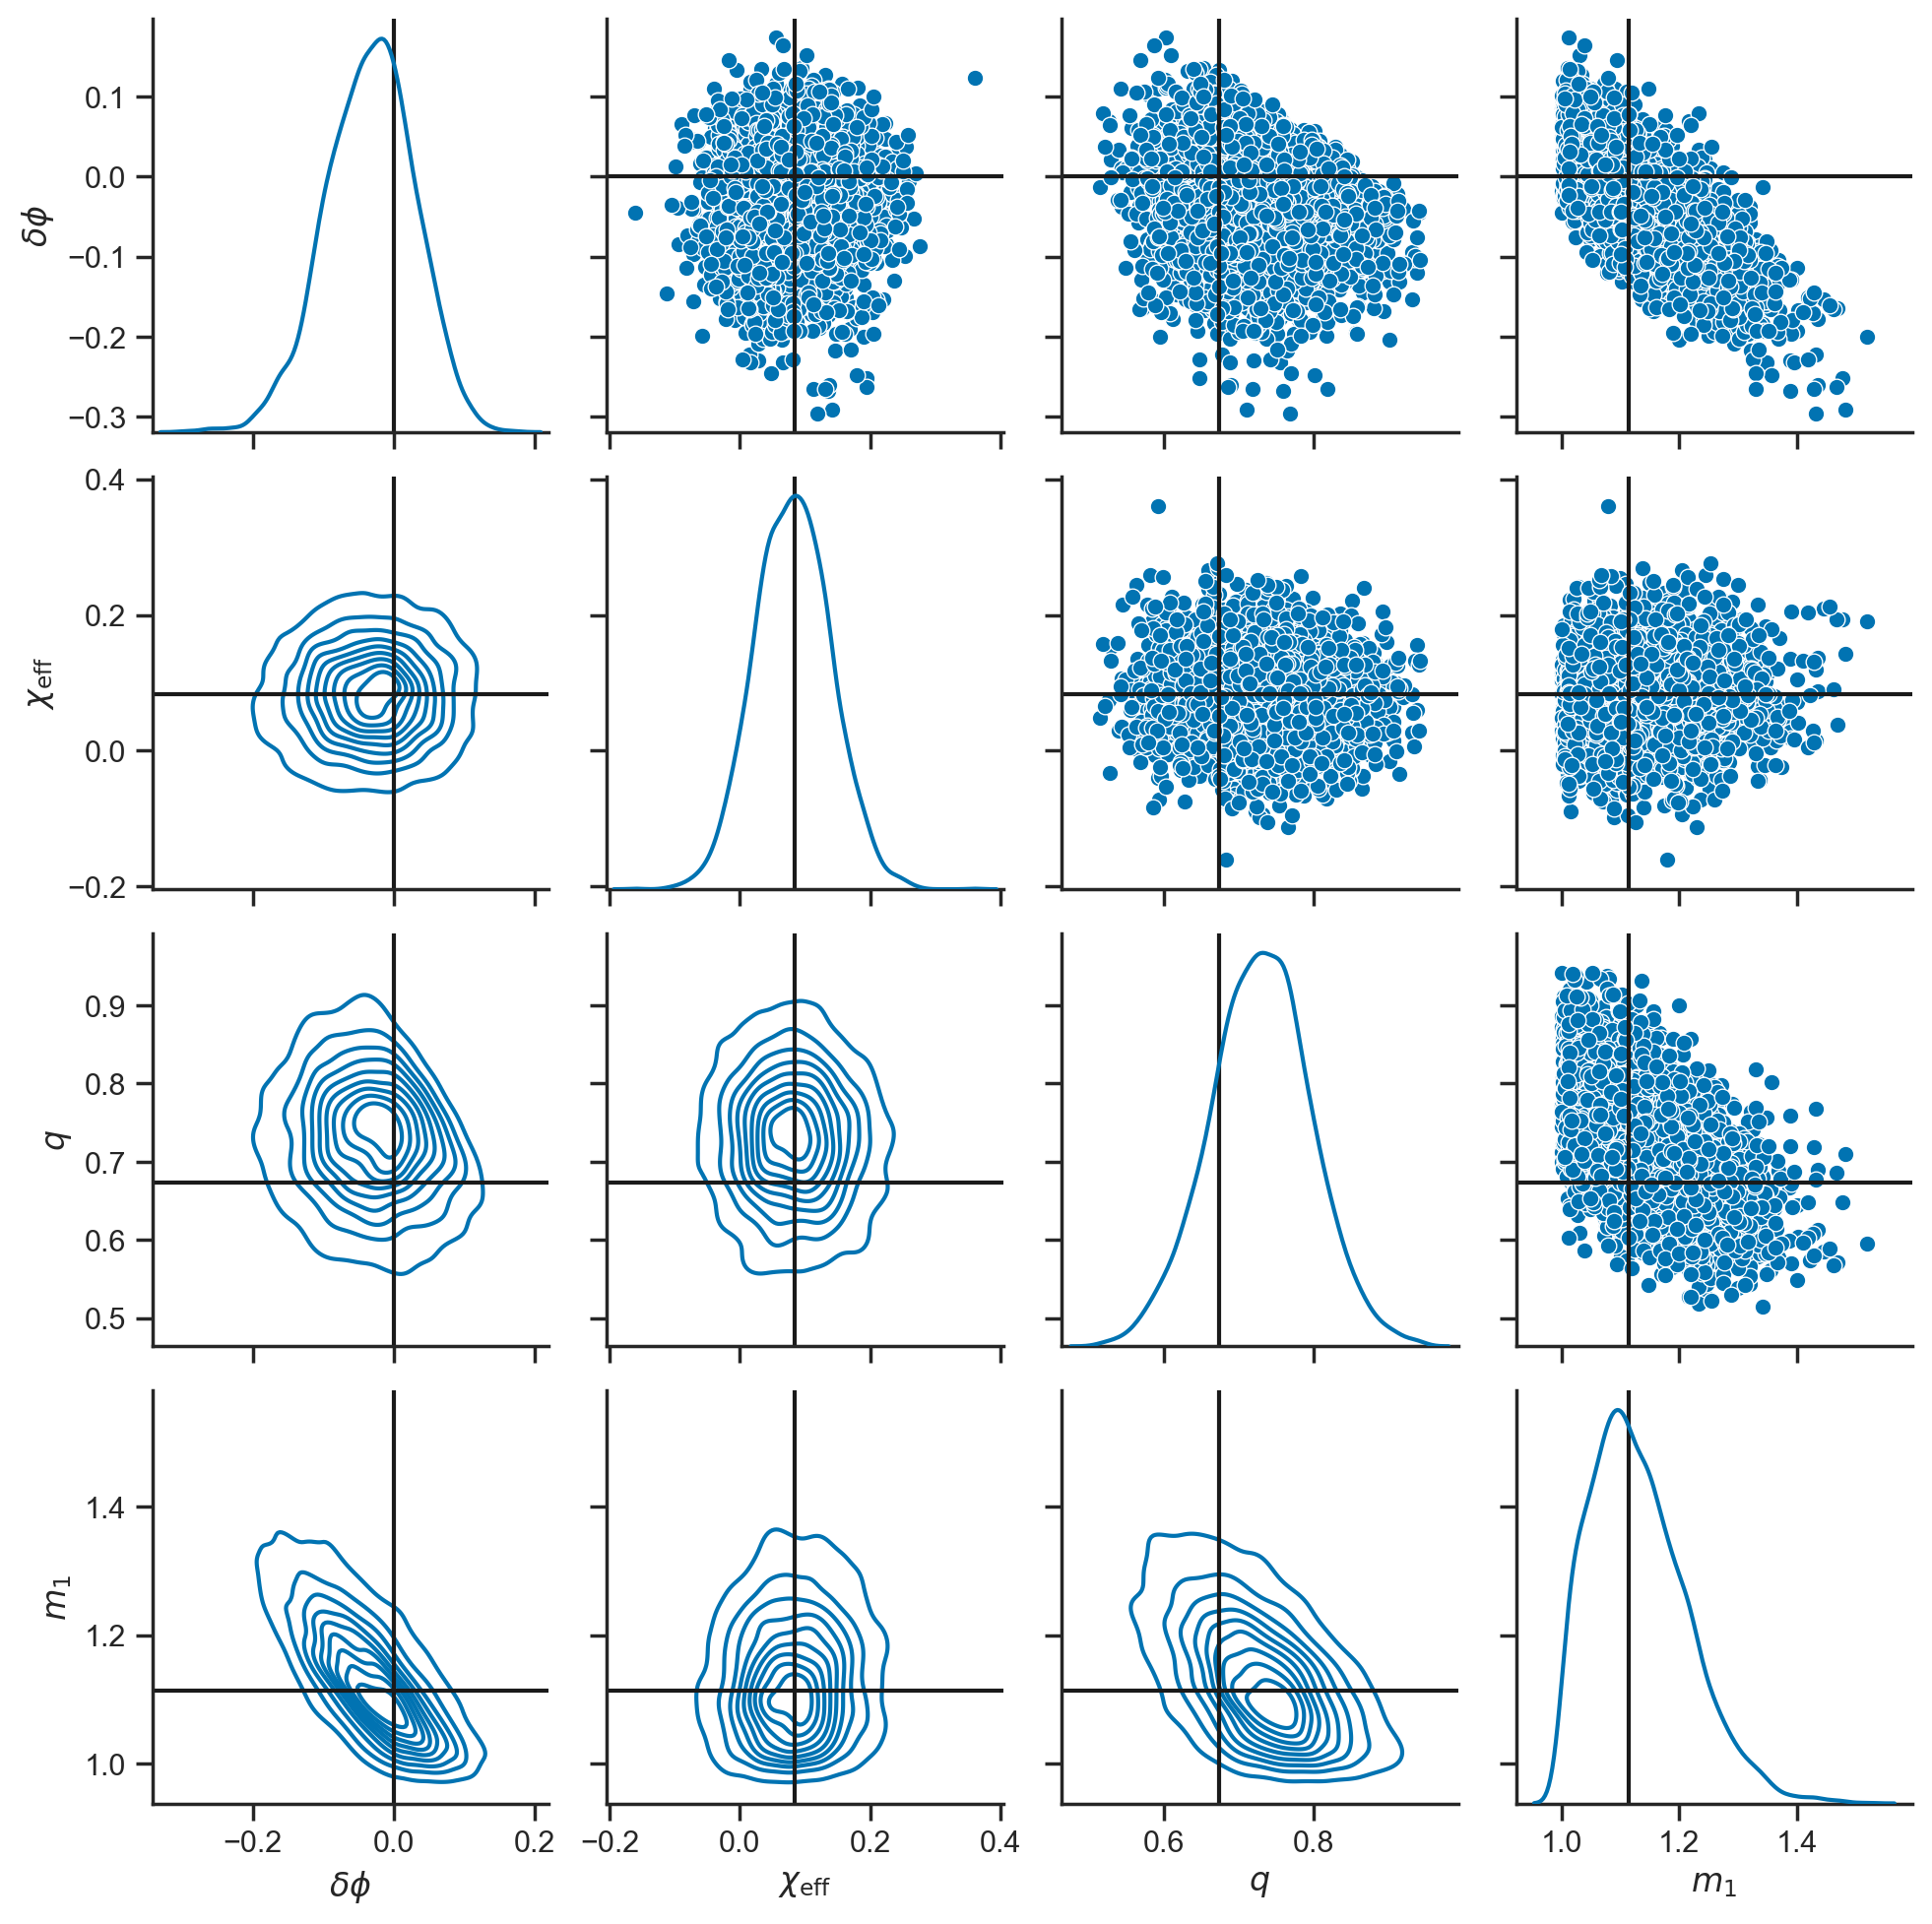

In [110]:
i = np.random.randint(nobs)
df = pd.DataFrame(data=samples[i,:,:], columns=[r'$\delta \phi$', r'$\chi_\mathrm{eff}$', r'$q$', r'$m_1$'])
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot)

t = [delta_phis[i], chi_eff[i], qs[i], m1s[i]]
for ii in range(4):
    for jj in range(4):
        if ii == jj:
            pg.axes[ii,jj].axvline(t[ii], color='k')
        else:
            pg.axes[ii,jj].axhline(t[ii], color='k')
            pg.axes[ii,jj].axvline(t[jj], color='k')

In [111]:
c = np.cov(samples[i,...], rowvar=False)
cc = conditional_covariance(samples[i,...], n=2)
e, evec = np.linalg.eigh(cc)

In [112]:
cor = c / np.sqrt(np.diag(c)[:, None]) / np.sqrt(np.diag(c)[None, :])

In [113]:
cor[0,:]

array([ 1.        , -0.00403446, -0.1839871 , -0.7361862 ])

<ErrorbarContainer object of 3 artists>

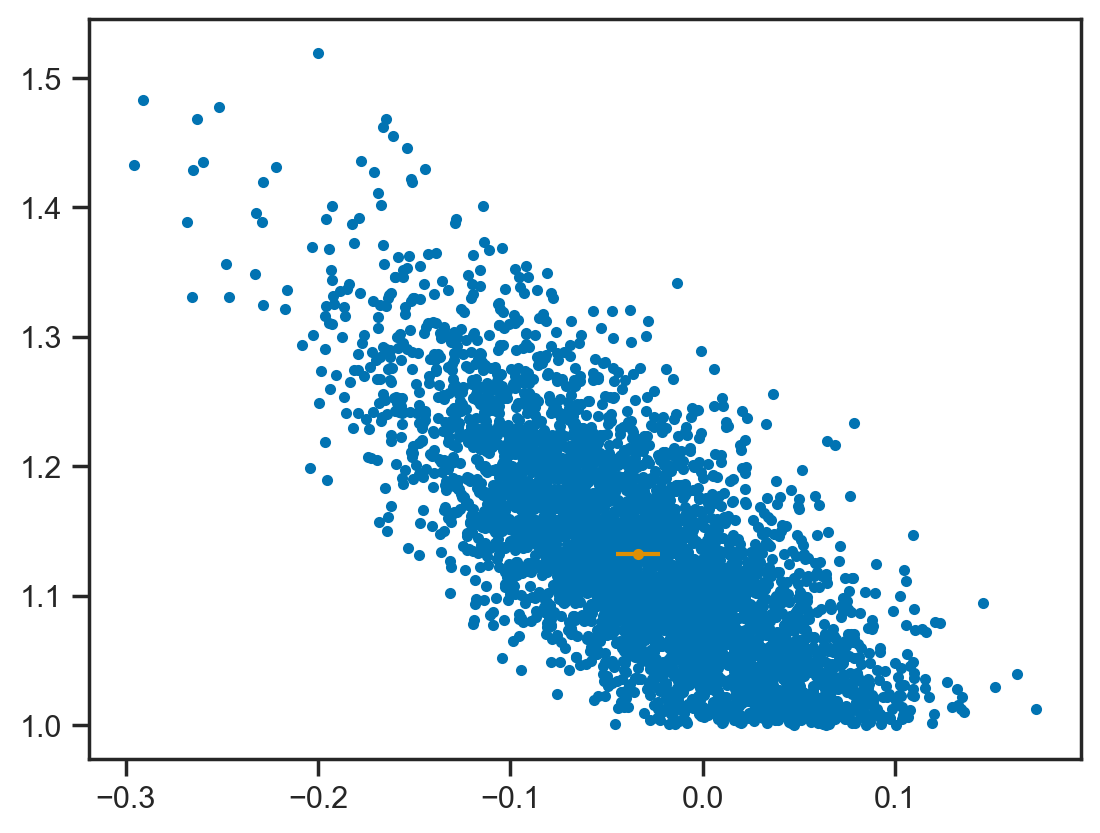

In [114]:
ii = 0
jj = 3
plt.plot(samples[i,:,ii], samples[i,:,jj], '.')
plt.errorbar(np.mean(samples[i,:,ii]), np.mean(samples[i,:,jj]), xerr=np.sqrt(e[ii]), yerr=0, fmt='.')

In [115]:
nmcmc = 1000
nchain = 4

kernel = NUTS(make_partial_normal_normal_model)
mcmc = MCMC(kernel, num_warmup=nmcmc, num_samples=nmcmc, num_chains=nchain)
mcmc.run(jax.random.PRNGKey(np.random.randint(1<<32)), samples, normal_wts, other_wts, nnormal)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [116]:
trace = az.from_numpyro(mcmc)

In [117]:
trace.posterior.neff.min()

<xarray.DataArray 'neff' ()>
array(14.00586, dtype=float32)

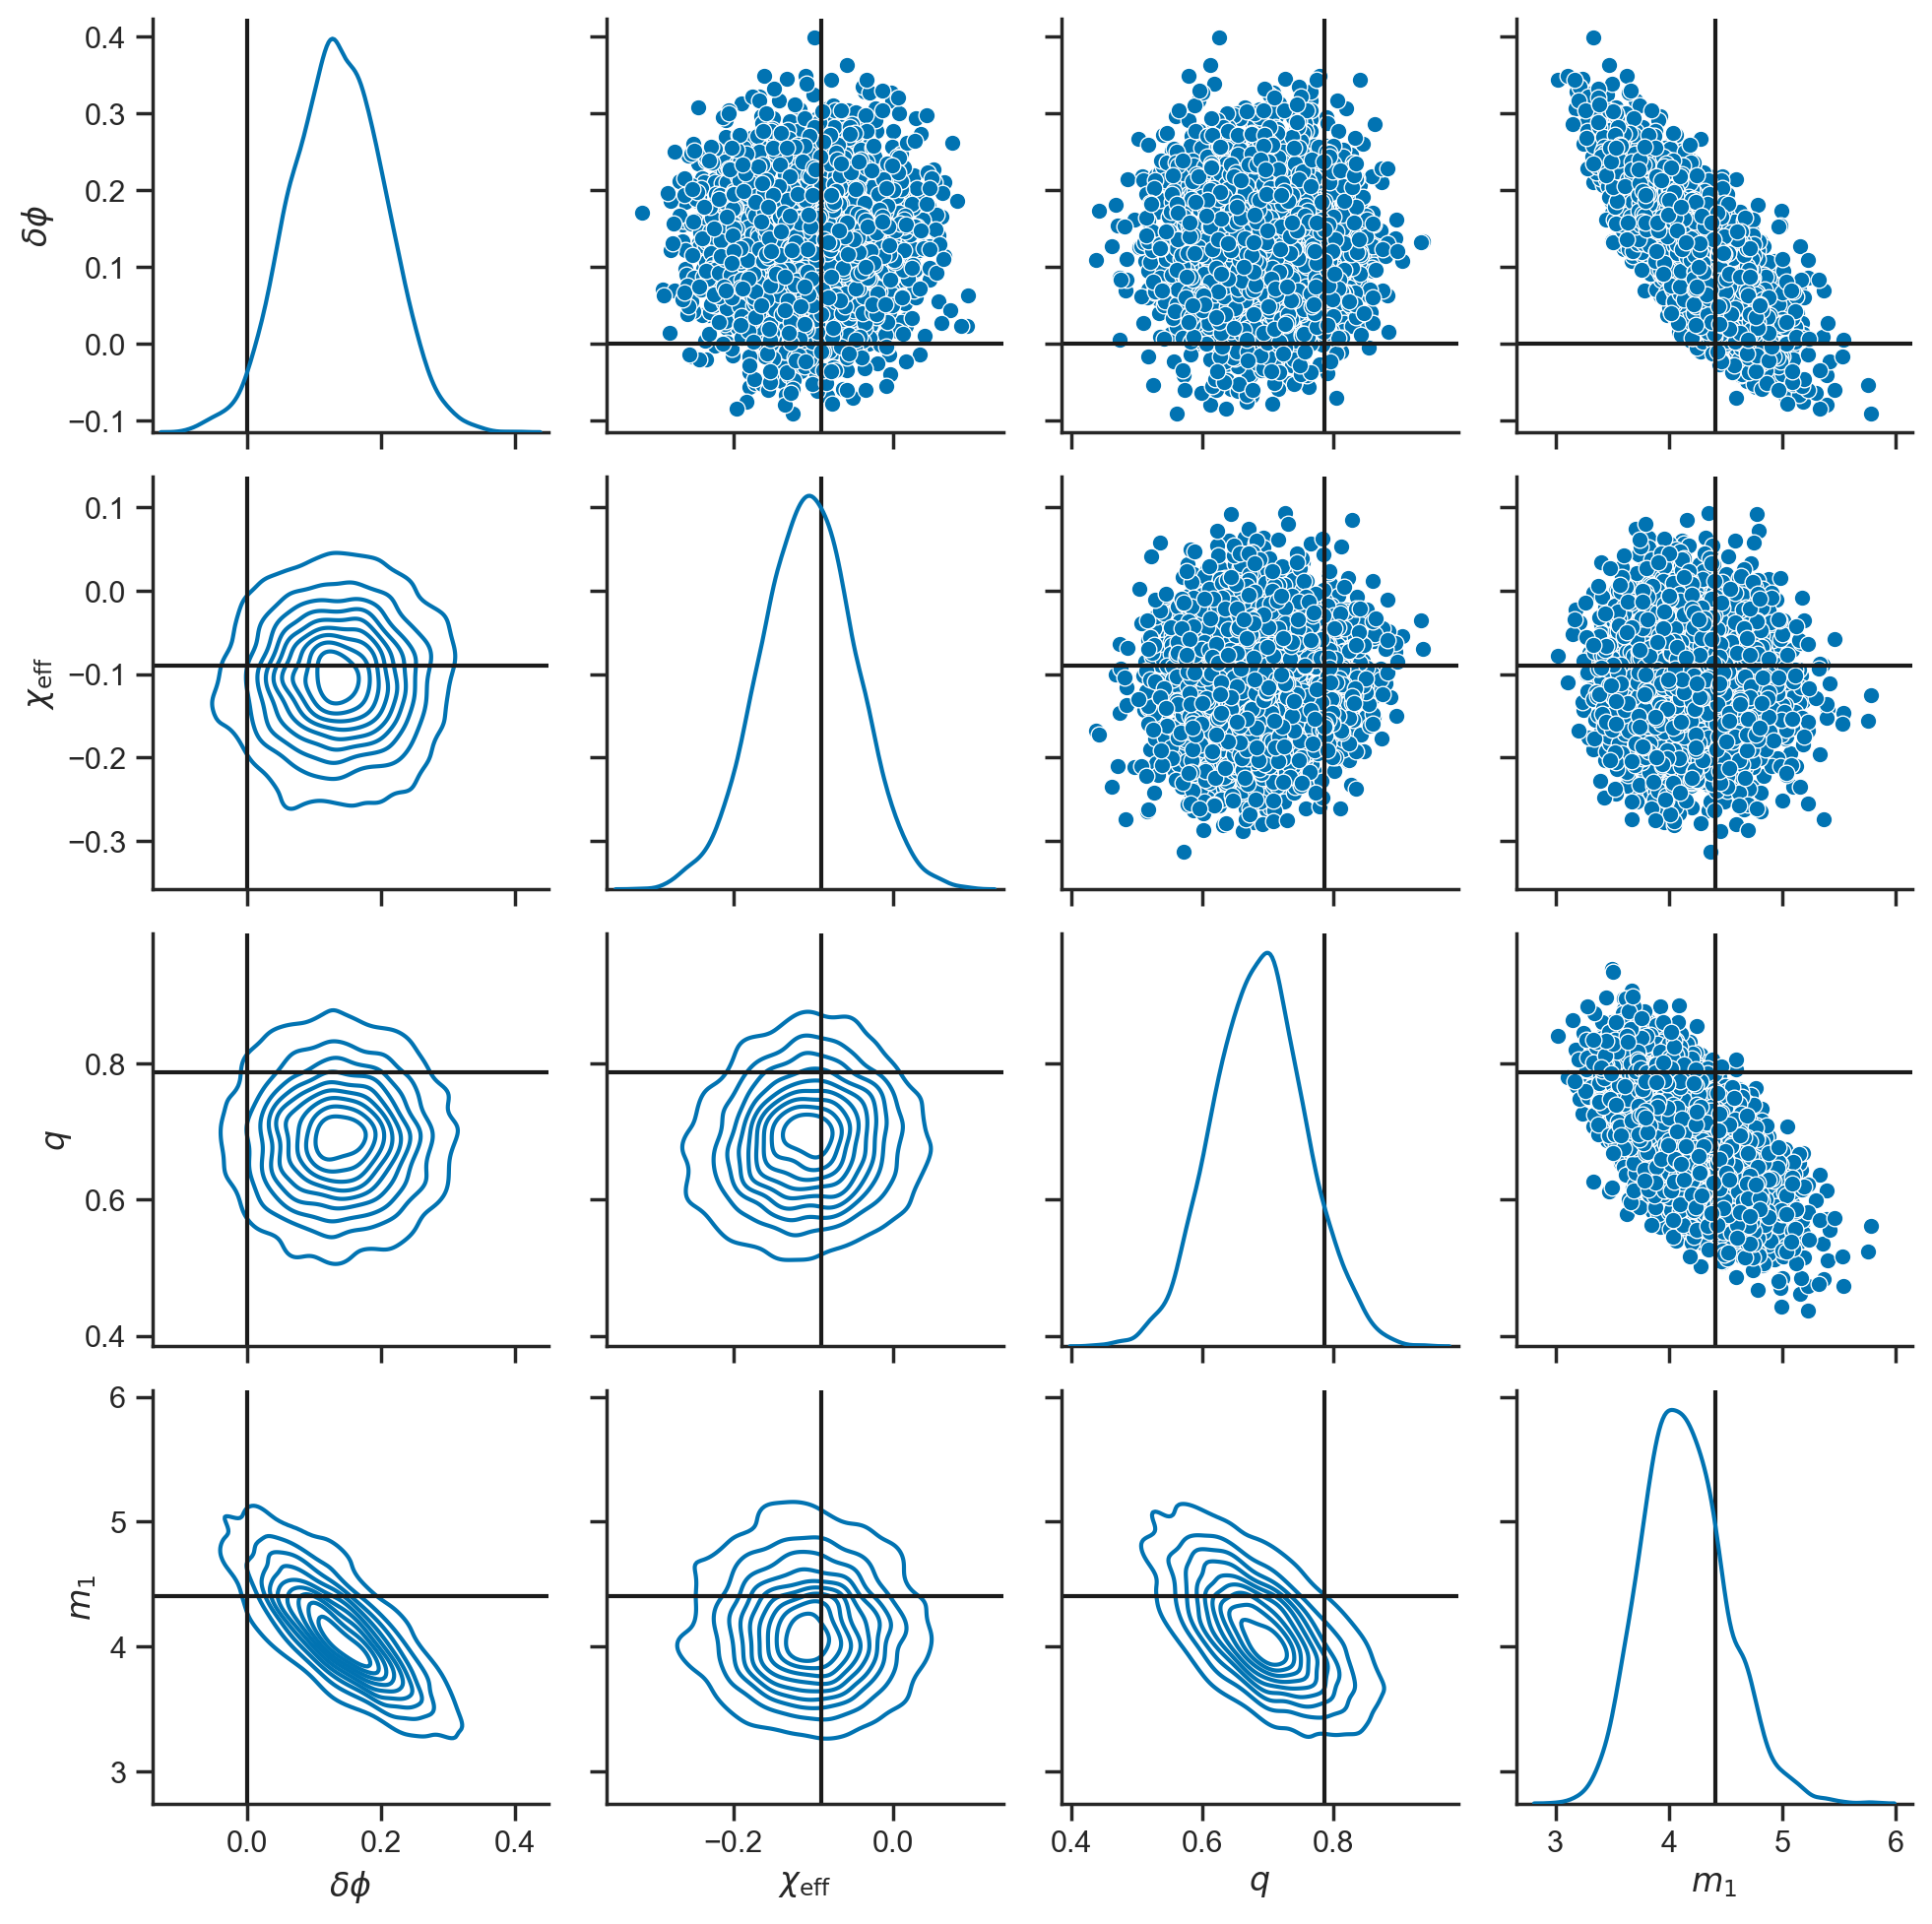

In [118]:
i = int(trace.posterior.neff.min(dim=['chain', 'draw']).argmin())
df = pd.DataFrame(data=samples[i,:,:], columns=[r'$\delta \phi$', r'$\chi_\mathrm{eff}$', r'$q$', r'$m_1$'])
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot)

t = [delta_phis[i], chi_eff[i], qs[i], m1s[i]]
for ii in range(4):
    for jj in range(4):
        if ii == jj:
            pg.axes[ii,jj].axvline(t[ii], color='k')
        else:
            pg.axes[ii,jj].axhline(t[ii], color='k')
            pg.axes[ii,jj].axvline(t[jj], color='k')

In [119]:
c = np.cov(samples[i,...], rowvar=False)
cc = conditional_covariance(samples[i,...], n=2)
e, evec = np.linalg.eigh(cc)

In [120]:
cor = c / np.sqrt(np.diag(c)[:, None]) / np.sqrt(np.diag(c)[None, :])

In [121]:
cor[0,:]

array([ 1.        ,  0.007548  ,  0.00925244, -0.77819854])

<ErrorbarContainer object of 3 artists>

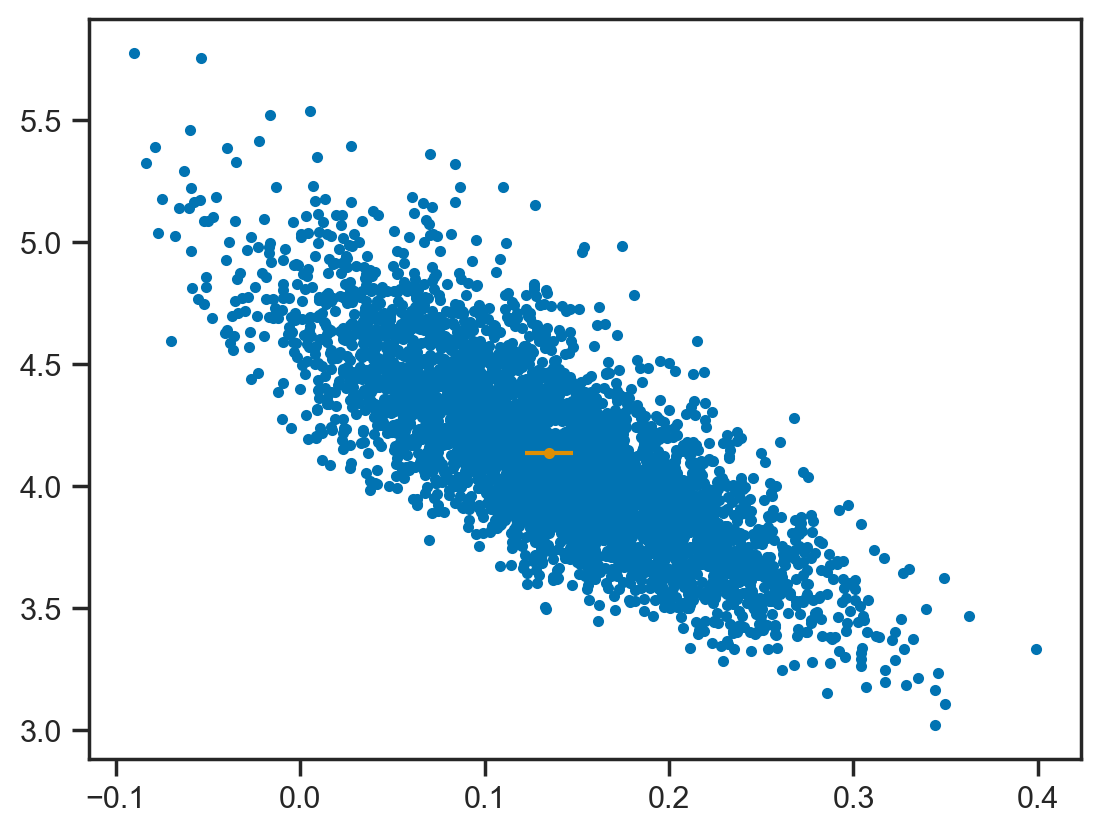

In [122]:
ii = 0
jj = np.argmax(np.abs(cor[0,1:])) + 1
plt.plot(samples[i,:,ii], samples[i,:,jj], '.')
plt.errorbar(np.mean(samples[i,:,ii]), np.mean(samples[i,:,jj]), xerr=np.sqrt(e[ii]), yerr=0, fmt='.')

In [123]:
i

28

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

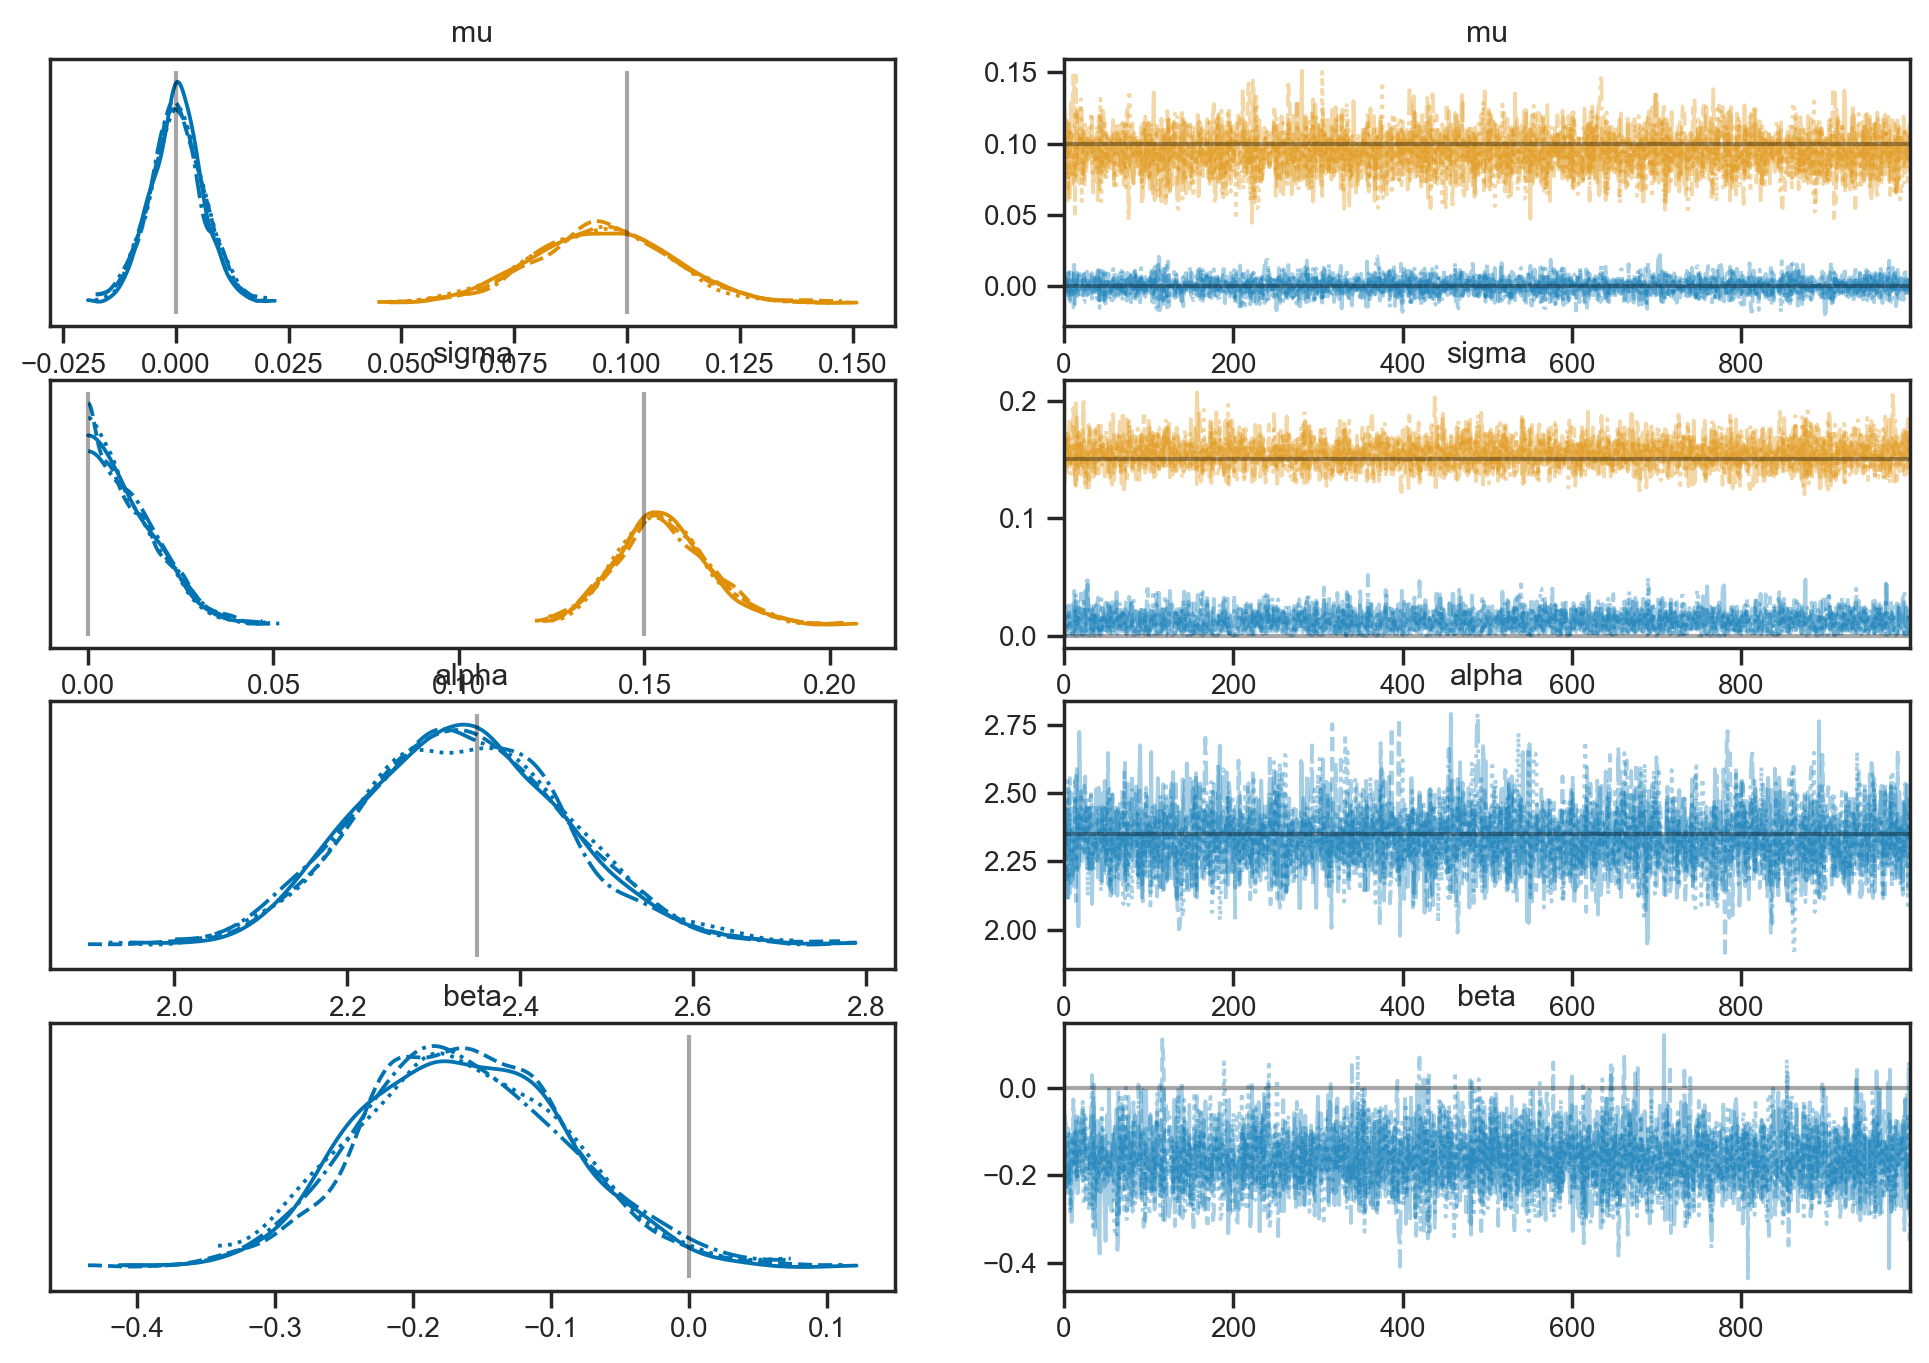

In [124]:
az.plot_trace(trace, var_names=['mu', 'sigma', 'alpha', 'beta'], lines=[('mu', {}, [0, chi_mu]), ('sigma', {}, [0, chi_sigma]), ('alpha', {}, alpha_true), ('beta', {}, beta_true)])

array([[<Axes: title={'center': 'mu\n0'}>,
        <Axes: title={'center': 'mu\n1'}>,
        <Axes: title={'center': 'sigma\n0'}>],
       [<Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

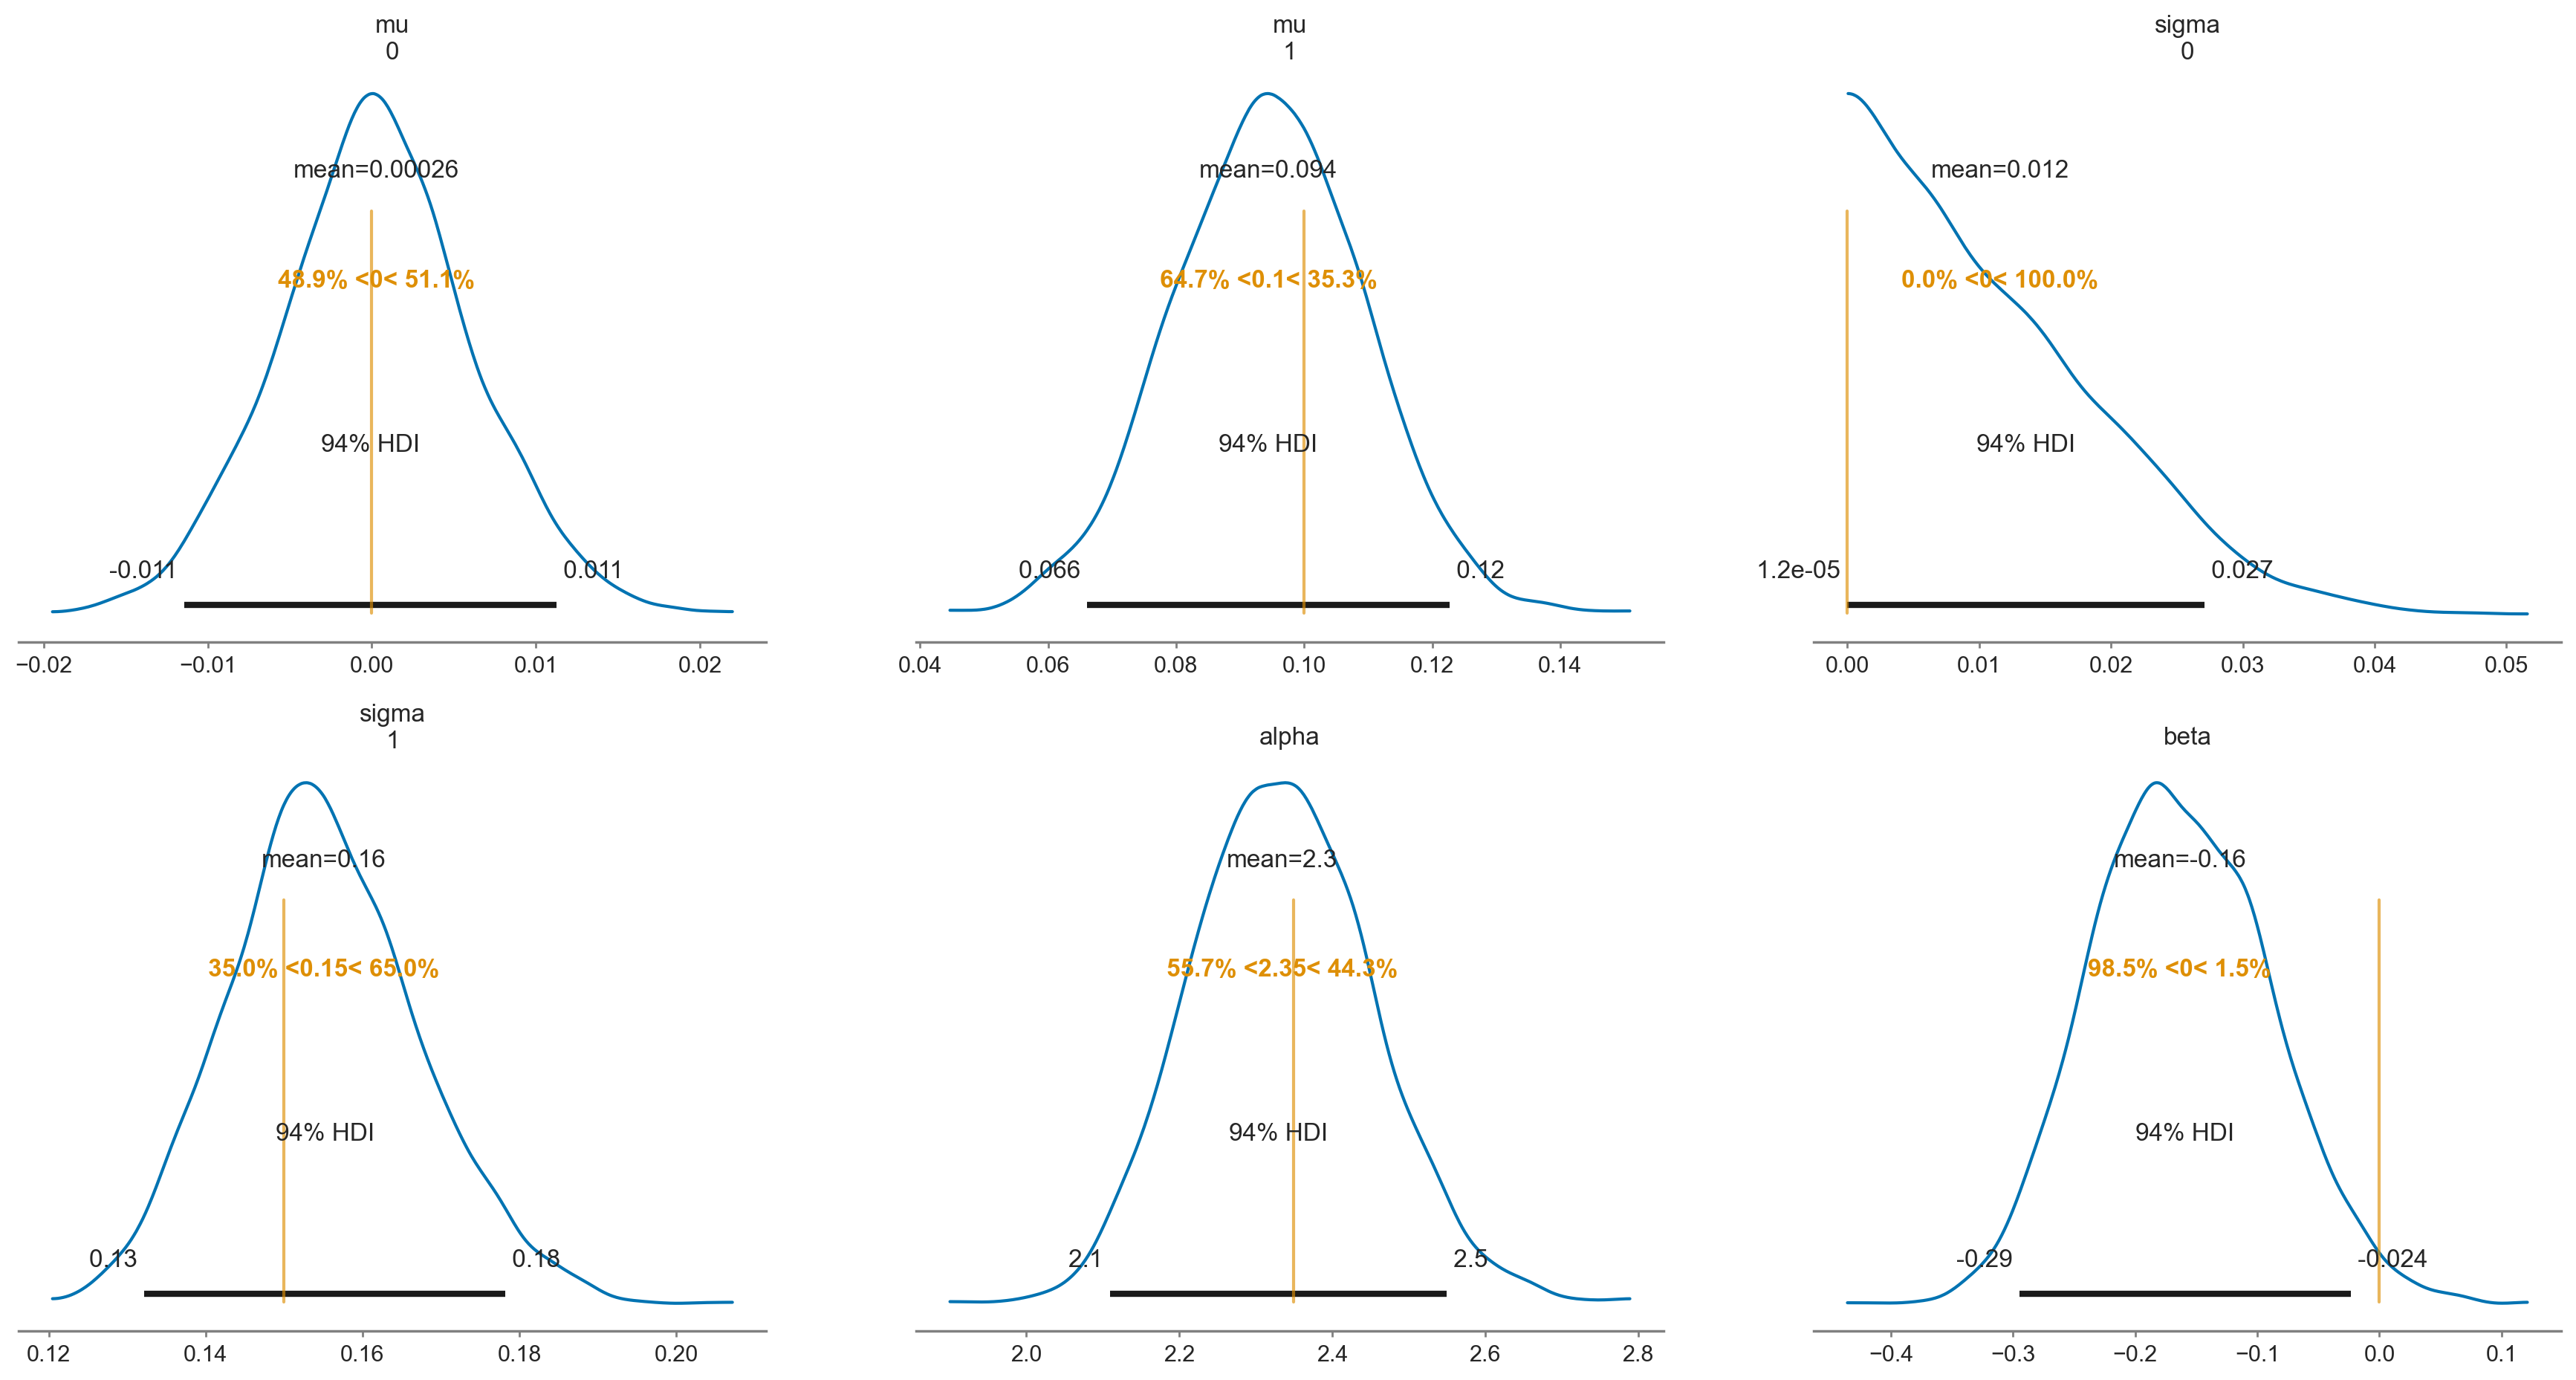

In [125]:
az.plot_posterior(trace, var_names=['mu', 'sigma', 'alpha', 'beta'], ref_val=[0, chi_mu] + [0, chi_sigma] + [alpha_true, beta_true])

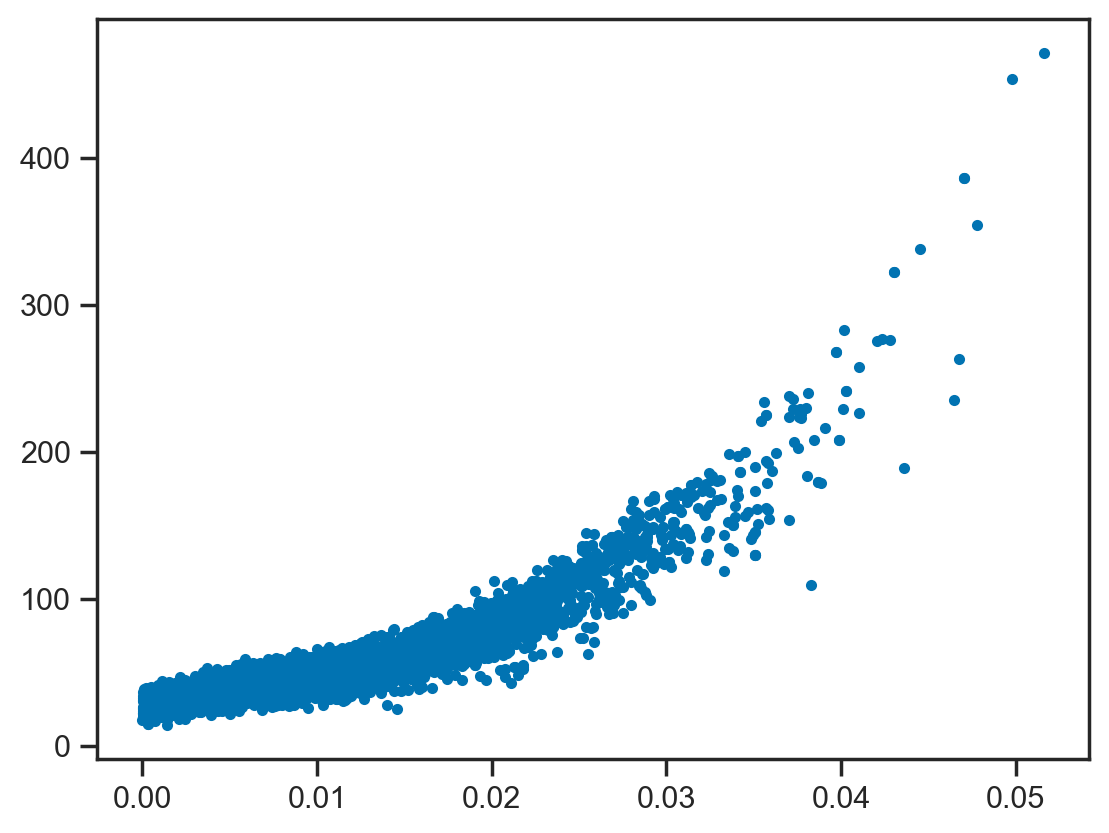

In [126]:
plt.plot(trace.posterior.sigma.sel(sigma_dim_0=0).values.flatten(), trace.posterior.neff.min(dim='neff_dim_0').values.flatten(), '.')

In [127]:
nmcmc = 1000
nchain = 4

kernel_nomarg = NUTS(make_partial_normal_normal_model)
mcmc_nomarg = MCMC(kernel_nomarg, num_warmup=nmcmc, num_samples=nmcmc, num_chains=nchain)
mcmc_nomarg.run(jax.random.PRNGKey(np.random.randint(1<<32)), samples, normal_wts, other_wts, nnormal, kde_marg=False)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [128]:
trace_nomarg = az.from_numpyro(mcmc_nomarg)

In [134]:
trace_nomarg.posterior.neff.min()

<xarray.DataArray 'neff' ()>
array(1.1920965, dtype=float32)

In [137]:
?jnp.linalg.solve

Signature:     
jnp.linalg.solve(
    a: Union[jax.Array, numpy.ndarray, numpy.bool_, numpy.number, bool, int, float, complex],
    b: Union[jax.Array, numpy.ndarray, numpy.bool_, numpy.number, bool, int, float, complex],
) -> jax.Array
Call signature: jnp.linalg.solve(*args, **kwargs)
Type:           PjitFunction
String form:    <PjitFunction of <function solve at 0x2811207c0>>
File:           ~/miniconda3/envs/mvnormal_kde_example/lib/python3.11/site-packages/jax/_src/numpy/linalg.py
Docstring:     
Solve a linear matrix equation, or system of linear scalar equations.

LAX-backend implementation of :func:`numpy.linalg.solve`.

*Original docstring below.*

Computes the "exact" solution, `x`, of the well-determined, i.e., full
rank, linear matrix equation `ax = b`.

Parameters
----------
a : (..., M, M) array_like
    Coefficient matrix.
b : {(..., M,), (..., M, K)}, array_like
    Ordinate or "dependent variable" values.

Returns
-------
x : {(..., M,), (..., M, K)} ndarray
    Soluti

In [ ]:
def make_marginal_normal_model(log_p_other, samples, prior_wts, n_normal):
    samples = np.atleast_3d(samples)
    prior_wts = np.atleast_2d(prior_wts)

    ndim = samples.shape[-2:]

    wts = 1/prior_wts
    W = np.sum(wts, axis=-1)
    neff = np.square(W) / np.sum(np.square(wts), axis=-1)

    log_wts = np.log(wts)

    mu = np.sum(wts[..., np.newaxis]*samples, axis=-2)/W[..., np.newaxis]
    sigma = np.sum(wts[..., np.newaxis, np.newaxis]*(samples[..., :, np.newaxis] - mu[..., :, np.newaxis])*(samples[..., np.newaxis, :] - mu[..., np.newaxis, :]), axis=-3) / W[..., np.newaxis, np.newaxis]

    kde_bw = sigma / neff[..., np.newaxis, np.newaxis]**(2/(4 + ndim))

    mu = numpyro.sample('mu', dist.Normal(0, 1), sample_shape=(n_normal,))
    sigmas = numpyro.sample('sigma', dist.HalfNormal(1), sample_shape=(n_normal,))

    eye_full = jnp.eye(ndim)

    mu_scaled_full = jnp.concatenate((mu / jnp.square(sigmas), jnp.zeros(ndim-n_normal)))
    y_shift = jnp.sum(kde_bw, mu_scaled_full[jnp.newaxis, :], axis=-1)
    y_shifted = samples + y_shift[..., jnp.newaxis, :]

    lam_inv_full = jnp.diag(jnp.concatenate((1/jnp.square(sigmas), jnp.zeros(ndim-n_normal))))
    mat = jnp.dot(kde_bw, lam_inv_full) + eye_full
    A = jnp.solve(mat, kde_bw)
    a = jnp.solve(mat, y_shifted)

    B = kde_bw[..., :n_normal, :n_normal] + jnp.diag(jnp.square(sigma))

    logp_normal = dist.MultivariateNormal(mu, B).log_prob(samples[..., :n_normal])

    logp_other_0 = log_p_other(a[..., n_normal:])

    logp_total = logp_normal + logp_other_0 + log_wts
    numpyro.factor(jnp.sum(jnp_logsumexp(logp_total, axis=-1)))

def make_full_model(samples, prior_wts, n_normal):
    alpha = numpyro.sample('alpha', dist.Uniform(1, 4))
    beta = numpyro.sample('beta', dist.Uniform(-1, 4))

    def log_p_other(s):
        q = s[..., 0]
        m1 = s[..., 1]

        return beta*jnp.log(q) + jnp.log1p(beta) - alpha*jnp.log(m1) + jnp.log(alpha - 1)
    
    make_marginal_normal_model(log_p_other, samples, prior_wts, n_normal)